In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import seaborn as sns
import warnings
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')

In [3]:
anime=pd.read_csv("C:/Users/rishi/OneDrive/Desktop/MSBAPM/SEM 1/OPIM 5604 - Predictive Modelling/Group Project/archive/anime.csv")
rating=pd.read_csv("C:/Users/rishi/OneDrive/Desktop/MSBAPM/SEM 1/OPIM 5604 - Predictive Modelling/Group Project/archive/rating.csv")

In [4]:
rating_knn = rating[rating.rating != -1]

In [5]:
rating_knn.shape
rating_knn

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


### Unique user Ids

In [6]:
rating_knn['user_id'].nunique()

69600

### Finding users with multiple ratings for the same Anime

In [7]:
duplicate = rating_knn[rating_knn.duplicated(subset=['user_id','anime_id'], keep=False)]
print (duplicate)
duplicate.shape

         user_id  anime_id  rating
4499243    42653      1575       8
4499244    42653      2001       8
4499255    42653     11757       8
4499258    42653     16498       8
4499261    42653     20507       7
4499263    42653     22319       8
4499266    42653     23283       8
4499286    42653      1575       6
4499288    42653      2001      10
4499307    42653     11757       5
4499316    42653     16498       8
4499320    42653     20507       9
4499325    42653     22319       6
4499326    42653     23283       9


(14, 3)

### Removing user 42653 with multiple ratings

In [8]:
rating_knn = rating_knn[rating_knn.user_id != 42653]
rating_knn.shape

(6337151, 3)

### Anime distribution by Type

In [9]:
anime['type'].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

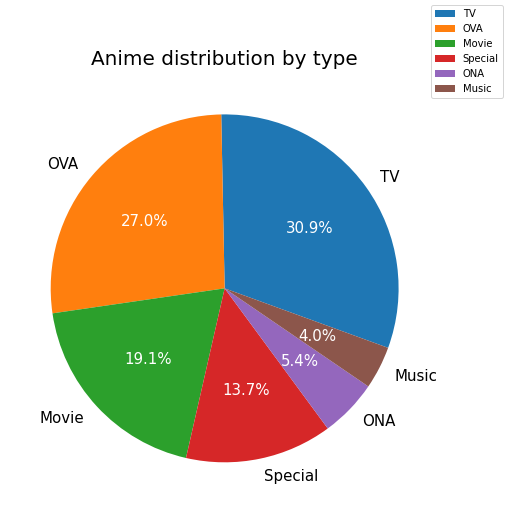

In [10]:
data=anime['type'].value_counts()
y=data.values
plt.figure(figsize=(8,8))
plt.title('Anime distribution by type',fontsize=20)
plt.style.use('tableau-colorblind10')
patches,l_text,p_text=plt.pie(y,labels=data.index, autopct='%.1f%%',startangle=-20)
for i in p_text:
    i.set_size(15)
    i.set_color('w')
for i in l_text:
    i.set_size(15)
plt.figlegend()
plt.show()

In [11]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

### Genre and Count

In [12]:
genre_count=collections.defaultdict(int)
for genres in anime['genre']:
    if not type(genres) is str:
        continue
    data=set()
    for genre1 in genres.split(', '):
        if genre1 in data:
            continue
        data.add(genre1)
        genre_count[genre1]+=1
sorted(genre_count.items(),key=lambda x:x[1], reverse=True)

[('Comedy', 4645),
 ('Action', 2845),
 ('Adventure', 2348),
 ('Fantasy', 2309),
 ('Sci-Fi', 2070),
 ('Drama', 2016),
 ('Shounen', 1711),
 ('Kids', 1609),
 ('Romance', 1464),
 ('School', 1220),
 ('Slice of Life', 1220),
 ('Hentai', 1141),
 ('Supernatural', 1037),
 ('Mecha', 944),
 ('Music', 860),
 ('Historical', 806),
 ('Magic', 778),
 ('Ecchi', 637),
 ('Shoujo', 603),
 ('Seinen', 547),
 ('Sports', 543),
 ('Mystery', 495),
 ('Super Power', 465),
 ('Military', 426),
 ('Parody', 408),
 ('Space', 381),
 ('Horror', 369),
 ('Harem', 317),
 ('Demons', 294),
 ('Martial Arts', 265),
 ('Dementia', 240),
 ('Psychological', 229),
 ('Police', 197),
 ('Game', 181),
 ('Samurai', 148),
 ('Vampire', 102),
 ('Thriller', 87),
 ('Cars', 72),
 ('Shounen Ai', 65),
 ('Shoujo Ai', 55),
 ('Josei', 54),
 ('Yuri', 42),
 ('Yaoi', 39)]

In [13]:
dict1=dict(genre_count)
x=dict1.keys()
y=dict1.values()
temp={'genre1':list(x),'count1':list(y)}
df=pd.DataFrame.from_dict(temp)
df=df.sort_values(by='count1',ascending=False)[:10]
df

,genre1,count1
10,Comedy,4645
4,Action,2845
5,Adventure,2348
6,Fantasy,2309
14,Sci-Fi,2070
0,Drama,2016
9,Shounen,1711
38,Kids,1609
1,Romance,1464
2,School,1220


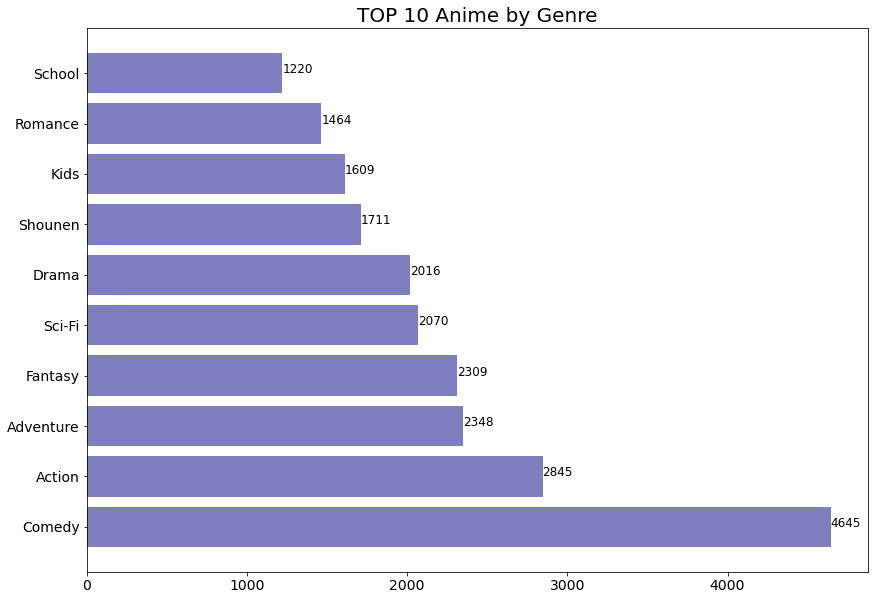

In [14]:
x=df.genre1
y=df.count1

plt.figure(figsize=(14,10))
#plt.style.use('seaborn')
plt.barh(x,y,color = 'navy',alpha=0.5)
plt.title('TOP 10 Anime by Genre',fontsize=20)
plt.tick_params(labelsize=14)
for i,j in zip(y,x):
    plt.text(i+0.1,j,i,fontsize=12)
plt.show()

### Merging Data

In [15]:
anime_fulldata=pd.merge(anime,rating_knn,on='anime_id',suffixes= [ '', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


In [16]:
combine_anime_rating = anime_fulldata.dropna(axis = 0, subset = ['anime_title'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['anime_title'])['user_rating'].
     count().reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']] )

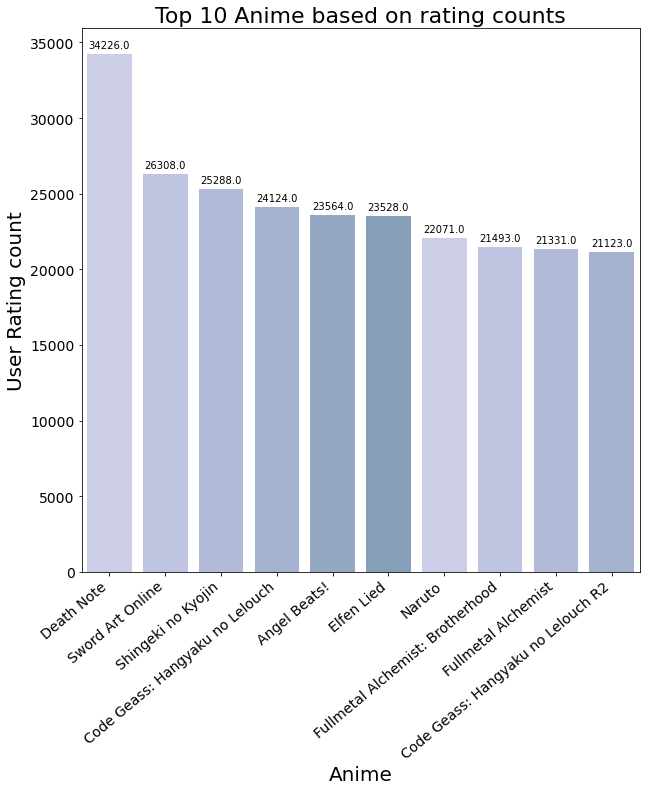

In [17]:
plt.figure(figsize=(10,10))
top10_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="user_rating", data=top10_animerating, palette = sns.cubehelix_palette(start = 2, dark=0.6, light=0.8))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)
plt.tick_params(labelsize=14)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

### Anime by Members

In [18]:
duplicate_anime=anime_fulldata.copy()
duplicate_anime.drop_duplicates(subset ="anime_title", 
                     keep = 'first', inplace = True)

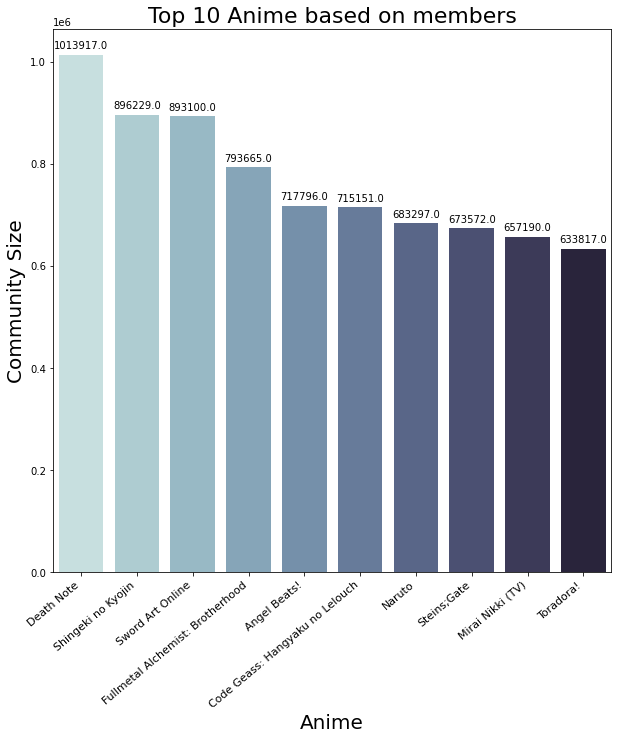

In [19]:
plt.figure(figsize=(10,10))
top10_animemembers=duplicate_anime[['anime_title', 'members']].sort_values(by = 'members',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="members", data=top10_animemembers, palette = "ch:start=.2,rot=-.3")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

### Keeping active users in ratings dataset

In [20]:
ratings_cnt = pd.DataFrame(rating_knn.groupby('user_id').size(),columns=['count'])
ratings_cnt.head()

,count
user_id,
1,4
2,1
3,92
5,459
7,343


In [21]:
na_thres_user=20
active_users = list(set(ratings_cnt.query('count >= @na_thres_user').index))

In [22]:
ratings_dropusers = rating_knn[rating_knn.user_id.isin(active_users)]

In [23]:
print(rating_knn.shape);print(ratings_dropusers.shape)

(6337151, 3)
(6164897, 3)


### Keeping popular anime

In [24]:
anime_cnt = pd.DataFrame(rating_knn.groupby('anime_id').size(),columns=['count'])
anime_cnt.head()

,count
anime_id,
1,13448
5,5789
6,9385
7,2169
8,308


In [25]:
anime_cnt['count'].describe()

count     9927.000000
mean       638.375239
std       1795.819116
min          1.000000
25%          9.000000
50%         57.000000
75%        395.000000
max      34226.000000
Name: count, dtype: float64

In [26]:
na_thres_anime=10
pop_anime = list(set(anime_cnt.query('count >= @na_thres_anime').index))

In [27]:
ratings_dropanime = ratings_dropusers[ratings_dropusers.anime_id.isin(pop_anime)]


In [28]:
print(ratings_dropusers.shape);print(ratings_dropanime.shape)

(6164897, 3)
(6156670, 3)


### Preparing data for KNN 

In [29]:
#rating_new=rating_new[:4000000]
KNN = ratings_dropanime.pivot(
    index='anime_id',
    columns='user_id',
    values='rating').fillna(0)

In [30]:
KNN.shape

(7365, 47152)

In [31]:
import scipy as sp

In [32]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [33]:
an1=anime[['anime_id','name']]

In [34]:
KNN

user_id,3,5,7,11,12,14,17,18,19,21,...,73499,73500,73501,73502,73503,73504,73507,73510,73513,73515
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.0,...,9.0,0.0,0.0,0.0,9.0,10.0,9.0,0.0,9.0,10.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,...,0.0,0.0,0.0,0.0,7.0,10.0,8.0,0.0,8.0,10.0
6,0.0,8.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,9.0,9.0,9.0,0.0,0.0,10.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,7.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34240,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
anime_to_idx = {
    an1: i  for i,an1 in 
    enumerate(list(an1.set_index('anime_id').loc[KNN.index].name))
}

In [36]:
KNN.shape

(7365, 47152)

In [37]:
KNN

user_id,3,5,7,11,12,14,17,18,19,21,...,73499,73500,73501,73502,73503,73504,73507,73510,73513,73515
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.0,...,9.0,0.0,0.0,0.0,9.0,10.0,9.0,0.0,9.0,10.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,...,0.0,0.0,0.0,0.0,7.0,10.0,8.0,0.0,8.0,10.0
6,0.0,8.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,9.0,9.0,9.0,0.0,0.0,10.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,7.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34240,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating sparse matrix

In [38]:
mat_knn = csr_matrix(KNN.values)

In [39]:
mat_knn

<7365x47152 sparse matrix of type '<class 'numpy.float64'>'
	with 6156670 stored elements in Compressed Sparse Row format>

In [40]:
from sklearn.neighbors import NearestNeighbors

In [41]:
#make an object for the NearestNeighbors Class.
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [42]:
# fit the dataset
m1=model_knn.fit(mat_knn)

In [43]:
m1

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [44]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [45]:
from fuzzywuzzy import fuzz

In [46]:
def fuzzy_matching(mapper, fav_anime, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for name, idx in mapper.items():
        ratio = fuzz.ratio(name.lower(), fav_anime.lower())
        if ratio >= 60:
            match_tuple.append((name, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [74]:
def make_recommendation(model_knn, data, mapper, fav_anime, n_recommendations):
    
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_anime)
    idx = fuzzy_matching(mapper, fav_anime, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_anime))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(10-i, reverse_mapper[idx], dist))

In [85]:
my_favorite = 'Naruto'

make_recommendation(
    model_knn=model_knn,
    data=mat_knn,
    fav_anime=my_favorite,
    mapper=anime_to_idx,
    n_recommendations=10)

You have input movie: Naruto
Found possible matches in our database: ['Naruto', 'Naruto x UT', 'Haruwo', 'Nayuta']

Recommendation system start to make inference
......

Recommendations for Naruto:
10: Code Geass: Hangyaku no Lelouch R2, with distance of 0.5130597756654479
9: Ao no Exorcist, with distance of 0.5120635609401583
8: Dragon Ball Z, with distance of 0.509612077335972
7: Shingeki no Kyojin, with distance of 0.4940601183746183
6: Bleach, with distance of 0.4913102070220363
5: Code Geass: Hangyaku no Lelouch, with distance of 0.4906028968861259
4: Fullmetal Alchemist: Brotherhood, with distance of 0.4891212798016209
3: Sword Art Online, with distance of 0.48735022030623
2: Fullmetal Alchemist, with distance of 0.4848301085349528
1: Death Note, with distance of 0.40289401820806015


### Content Based Filtering

#### Dropping columns - episodes, rating ad members as they are Target leakages

In [55]:
anime1 = anime.drop(['episodes', 'rating', 'members'], axis=1)

#### Dropping Anime with null values for genre and type

In [56]:
anime1 = anime1[anime1.genre.notna()]
anime1.shape

(12232, 4)

In [57]:
anime1 = anime1[anime1.type.notna()]
anime1.shape

(12210, 4)

In [88]:
anime1

,anime_id,name,genre,type
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV
...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA
12290,5543,Under World,Hentai,OVA
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA


#### One-Hot encoding

In [58]:
anime_features = pd.concat([anime1[["anime_id"]], anime1["genre"].str.get_dummies(sep=","),
                            pd.get_dummies(anime1[["type"]])],axis=1)

In [59]:
anime_features = anime_features.set_index('anime_id')

In [60]:
anime_features = anime_features.fillna(0)

In [61]:
mat_anm = csr_matrix(anime_features.values)

#### KNN model

In [76]:
model_anm = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(mat_anm)

In [77]:
distances, indices = model_anm.kneighbors(anime_features)

In [78]:
def get_index_from_name(name):
    return anime[anime["name"]==name].index.tolist()[0]

In [79]:
all_anime_names = list(anime.name.values)

In [80]:
def get_id_from_partial_name(partial):
    for name in all_anime_names:
        if partial in name:
            print(name,all_anime_names.index(name))

In [81]:
""" print_similar_query can search for similar animes both by id and by name. """

def print_similar_animes(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(anime.loc[id]["name"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(anime.loc[id]["name"])

#### Recommendations

In [82]:
print_similar_animes(query="Naruto")

Naruto: Shippuuden
Katekyo Hitman Reborn!
Naruto Shippuuden: Sunny Side Battle
Yumemi Douji
Shijou Saikyou no Deshi Kenichi
Kaitou Joker 4th Season
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono
Owari no Seraph: Kyuuketsuki Shahar
Bleach
Super Doll Licca-chan


In [91]:
print_similar_animes('Pokemon: The Origin')

Onboro Film
Nichijou: Tanken Nichijou no Machi
Pokemon: The Origin
Overlord: Ple Ple Pleiades (OVA)
Panda-Z: The Robonimation
Pokemon Best Wishes! Season 2: Episode N
Pokemon XY: Mega Evolution
Pokemon the Movie XY&amp;Z: Volcanion to Karakuri no Magiana
Haiyoru! Nyaruani
Pokemon Diamond &amp; Pearl: Arceus Choukoku no Jikuu e


In [71]:
print_similar_animes('Shinchan')

IndexError: list index out of range